In [1]:
# Data Manipulation and Preprocessing
import numpy as np
import pandas as pd
import json
import labtools

# Data Visualization
import matplotlib.pyplot as plt

import warnings
# Suppress the SettingWithCopyWarning
warnings.filterwarnings('ignore')

# Web Interaction and Display
from IPython.display import Image, display, HTML

# Additional JavaScript for toggling code display in Jupyter Notebooks
HTML(
    """
<script src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js "></script>
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
 } else {
 $('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit"
    value="Click here to toggle on/off the raw code."></form>
"""
)

C:\Users\admin\AppData\Local\Temp\ipykernel_11340\2931702184.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
final_df = pd.read_csv('final_df.csv')

<div style="background-color:#711012; text-align:center; padding: 10px 0;">
    <h2 style="color: white; font-weight:bold">SUPPLEMENTARY NOTEBOOK (1995-2024 - 500 Samples)</h2>
</div>

This notebook contains the implementation of the clustering method applied to the abstracts of research publications released between 1995 and 2000.

---

<div style="background-color:#711012; text-align:center; padding: 10px 0;">
    <h2 style="color: white; font-weight:bold">TOKEN VECTORIZATION</h2>
</div>

This is a list of consolidated abstracts of two publications submitted between 1995 and 2024 using only 500 samples per year.

In [3]:
years = list(range(1995, 2024))
samples_per_year = 500  # Set the desired number of samples per year

samples = []
for year in years:
    year_df = final_df[final_df['year'] == year]
    # Check if the year has at least the desired number of samples
    if len(year_df) >= samples_per_year:
        sample = year_df.sample(n=samples_per_year, random_state=42) 
    else:
        # Option 1: Take all available samples if fewer than desired
        sample = year_df
    samples.append(sample)

# Concatenate the sampled DataFrames
df_500 = pd.concat(samples, ignore_index=True)

# Extract the abstracts from the sampled DataFrame
abs_500 = df_500['abstract'].tolist()

# Printing the first 2 abstracts as a check
print(abs_500[:2])

["  Multiclass learning problems involve finding a definition for an unknown\nfunction f(x) whose range is a discrete set containing k &gt 2 values (i.e., k\n``classes''). The definition is acquired by studying collections of training\nexamples of the form [x_i, f (x_i)]. Existing approaches to multiclass learning\nproblems include direct application of multiclass algorithms such as the\ndecision-tree algorithms C4.5 and CART, application of binary concept learning\nalgorithms to learn individual binary functions for each of the k classes, and\napplication of binary concept learning algorithms with distributed output\nrepresentations. This paper compares these three approaches to a new technique\nin which error-correcting codes are employed as a distributed output\nrepresentation. We show that these output representations improve the\ngeneralization performance of both C4.5 and backpropagation on a wide range of\nmulticlass learning tasks. We also demonstrate that this approach is robu

We next create a matrix representing certain words on this list as a column and their corresponding frequencies within each abstract as values in the matrix. This matrix allows for quantitative analysis of the abstracts based on the occurrence of specific keywords or terms. 

To determine the optimal values for `min_df` and `max_df`, we created a heatmap that shows the sparsity of the TF-IDF matrix for different combinations of `min_df` and `max_df` values. The sparsity is calculated as the ratio of zero elements in the matrix to the total number of elements.

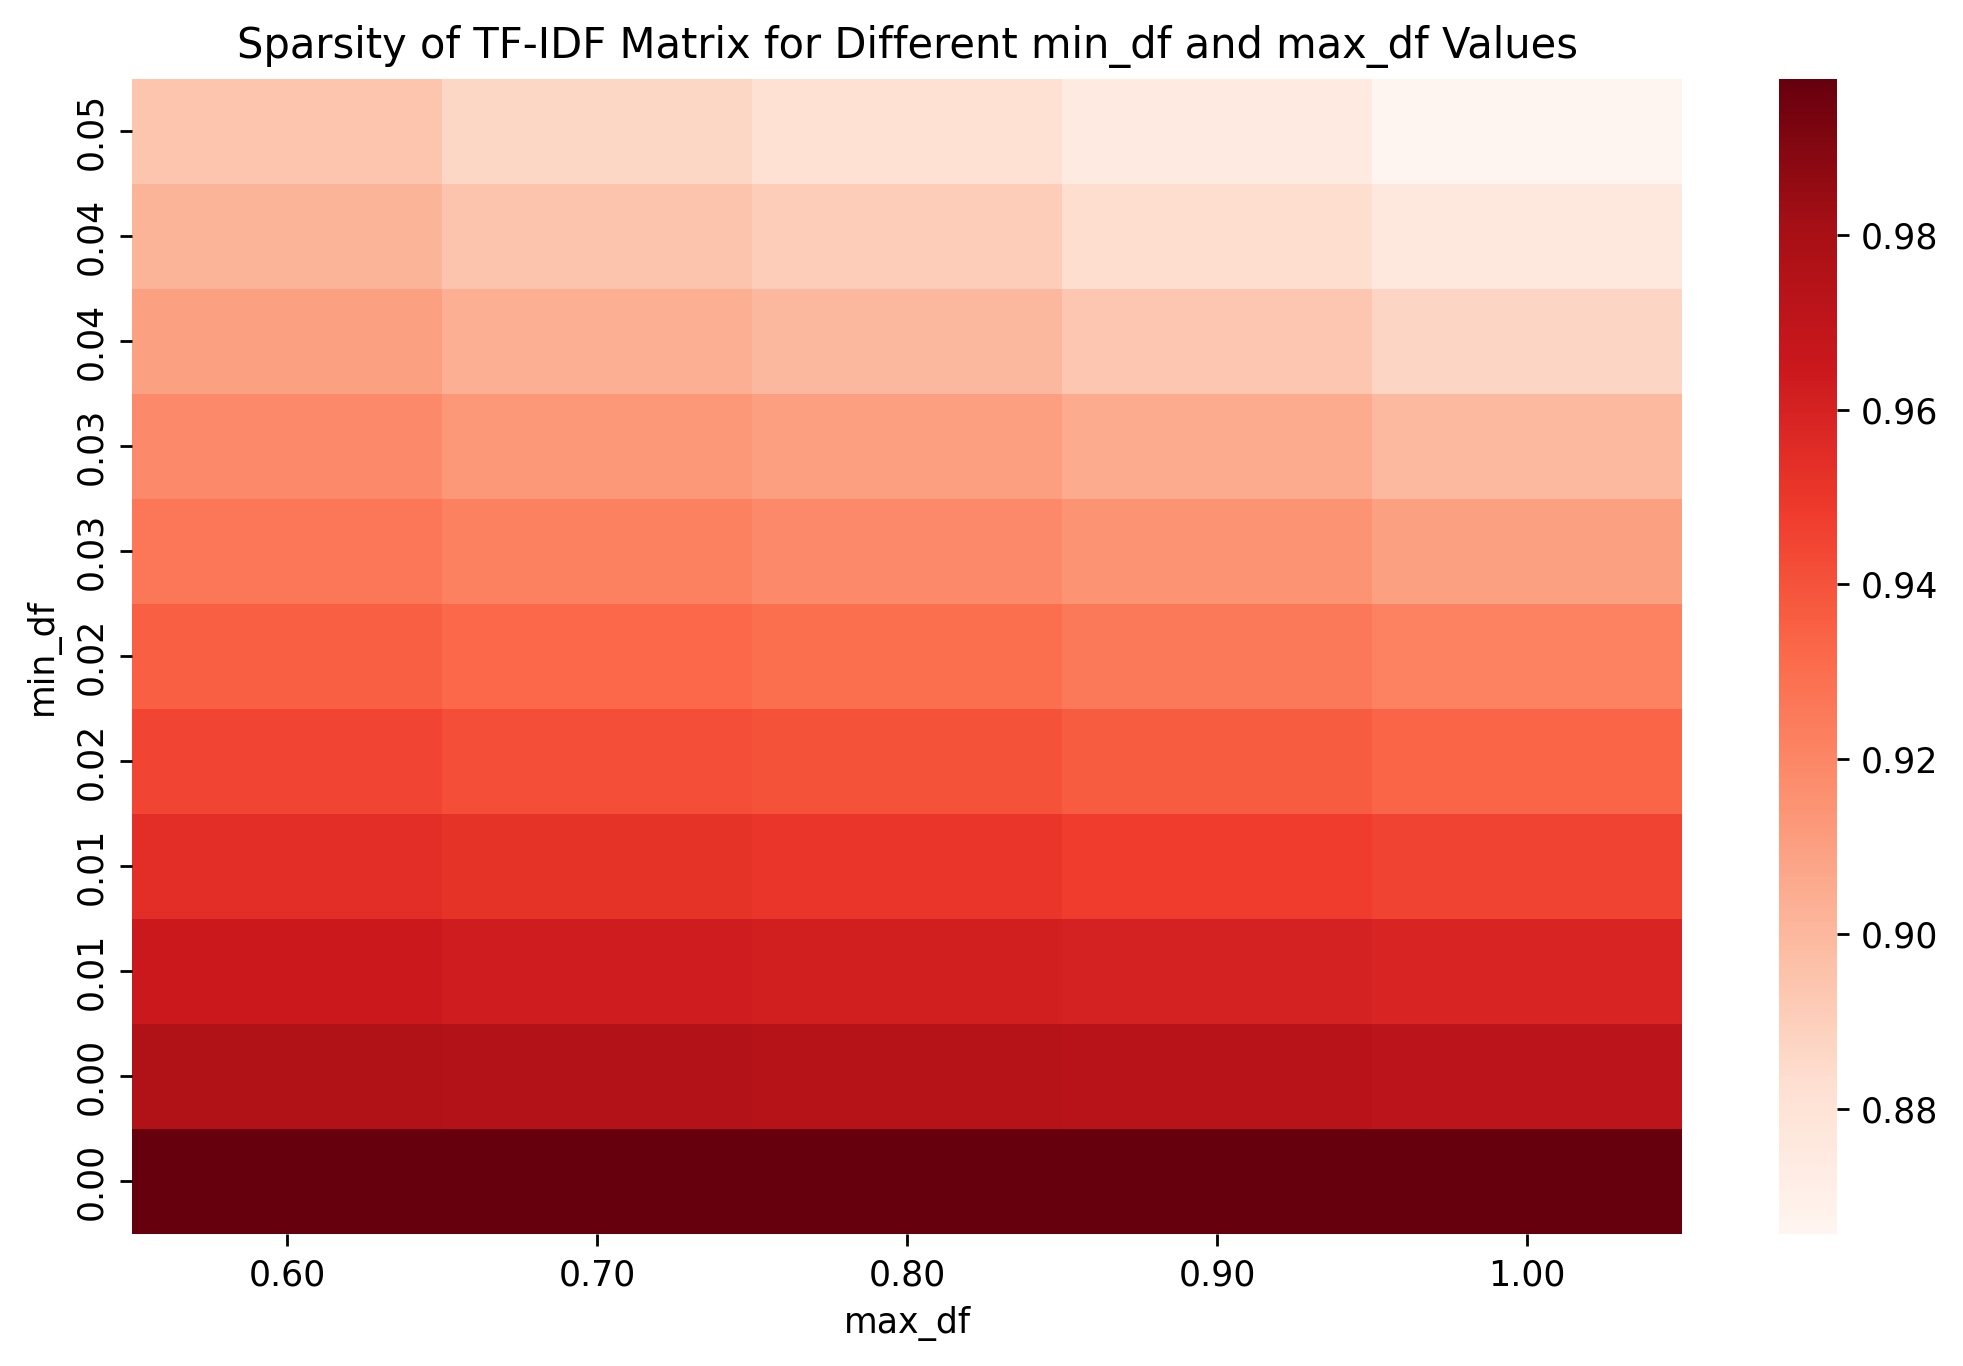

In [4]:
labtools.visualize_sparsity(abs_500)

<div style="text-align: center;">
    <h6>
        <b>Figure 1.</b> Sparsity of TF-IDF Matrix for Different <code>min_df</code> and <code>max_df</code> values
    </h6>
</div>

- **Lower right corner (high `min_df`, low `max_df`)**: This region has the lowest sparsity, indicating that most terms are included in the vocabulary due to the lenient filtering.
- **Upper left corner (low `min_df`, high `max_df`)**: This region has the highest sparsity, indicating that many terms have been excluded from the vocabulary due to the aggressive filtering of rare and common terms.
- **Diagonal trend**: As you move from the upper left corner to the lower right corner, the sparsity generally increases. This is because increasing `min_df` and decreasing `max_df` results in more aggressive filtering of the vocabulary.

The heatmap highlights the trade-off between sparsity and vocabulary size. A sparser matrix (higher sparsity) may be more computationally efficient, but it may also exclude important terms. A denser matrix (lower sparsity) includes more terms but may also include noise.

We chose the middle of the heatmap as the optimal region for the values of `min_df` and `max_df`, indicating a balance between including informative terms and excluding noise.

Let's also remove English and context-specific stopwords. Our resulting matrix looks like this:

In [5]:
df_tfidf_500 = labtools.vectorize_abstract(abs_500, min_df=0.03, max_df=0.8)
df_tfidf_500.head(3)

accuracy  achieve  addition  address  algorithm  algorithms  analysis  \
0         0        0         0        0          0    0.273766         0   
1         0        0         0        0   0.340109    0.127328         0   
2         0        0         0        0          0    0.186021         0   

   applied     apply  approaches  ...  transition  underlying  uniform  \
0        0         0     0.15731  ...           0           0        0   
1        0  0.156488           0  ...           0           0        0   
2        0         0           0  ...           0           0        0   

   unknown  upper    values  variable  variables  variance  weak  
0  0.09267      0  0.082022         0          0         0     0  
1        0      0         0         0          0         0     0  
2        0      0         0         0          0         0     0  

[3 rows x 276 columns]

<div style="text-align: center;">
    <h6>
        <b>Table 1.</b>TF-IDF Matrix
    </h6>
</div>


<div style="background-color:#711012; text-align:center; padding: 10px 0;">
    <h2 style="color: white; font-weight:bold">DIMENSIONALITY REDUCTION</h2>
</div>

Next, we reduce the complexity of the dataset by decreasing the number of its dimensions. We first determine the number of singular vectors that would give us at least 90% of the variance explained using the `TruncatedSVD` method.

Number of components for at least 90% variance explained: 218


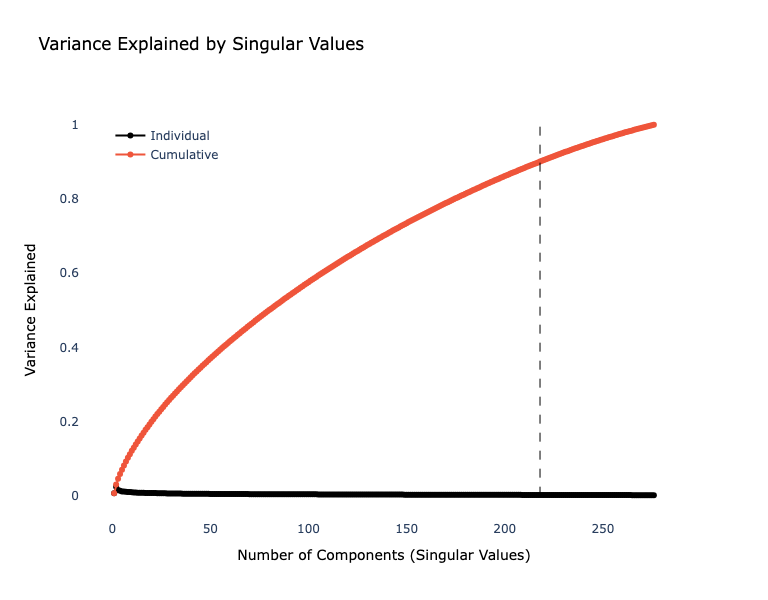

218

In [6]:
labtools.get_n_components(df_tfidf_500, show_viz=True)

<div style="text-align: center;">
    <h6>
        <b>Figure 2.</b> Individual and Cumulative Variance Explained of the SV Components
    </h6>
</div>

We then proceed to reducing the number of dimensions of our dataset based on the initial check.

In [7]:
reduced_500 = (labtools
               .reduce_dimensions(labtools.get_n_components(df_tfidf_500, 
                                                         show_viz=False),
                                  df_tfidf_500))

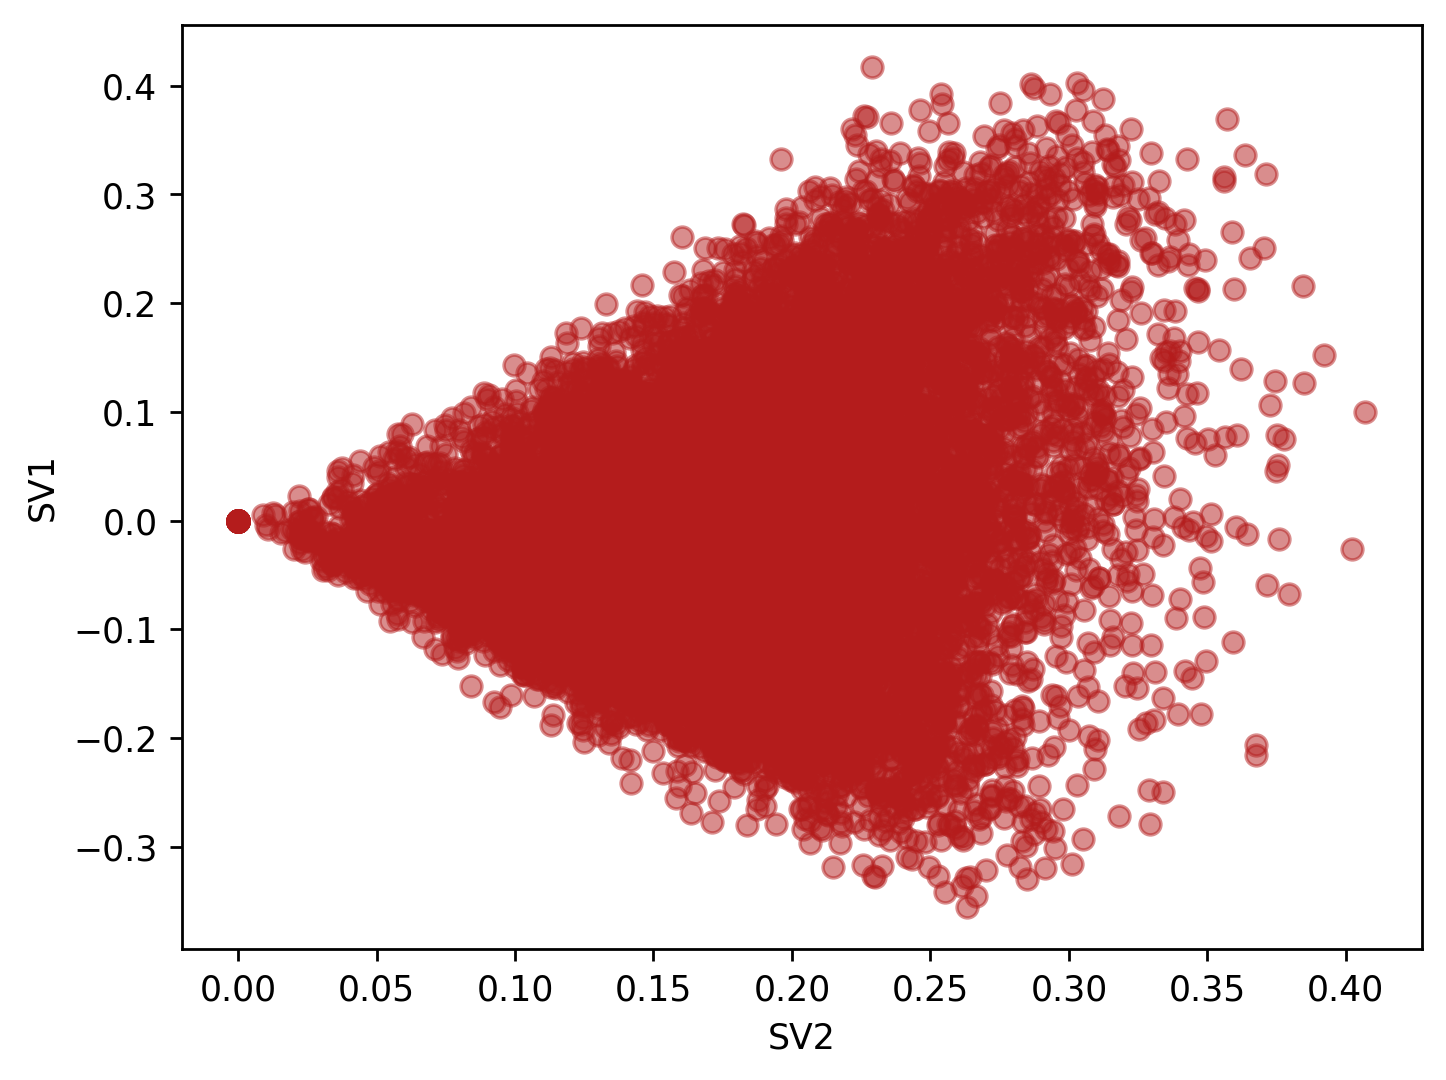

In [8]:
plt.figure(dpi=250)
plt.scatter(reduced_500[:, 0], reduced_500[:, 1], alpha=0.5, color='#b41c1c')
plt.xlabel('SV2')
plt.ylabel('SV1');

<div style="text-align: center;">
    <h6>
        <b>Figure 3.</b> The TF-IDF as projected to the first two singular vectors
    </h6>
</div>



The scatter plot for the 500 samples displays a dense, triangular distribution of points, suggesting a high degree of similarity among the samples with a broad base of common features that dips into more specialized or outlier topics as one moves along the axes. This shape may indicate a field with foundational commonalities that branches into diverse, yet related, areas of research.

<div style="background-color:#711012; text-align:center; padding: 10px 0;">
    <h2 style="color: white; font-weight:bold">CLUSTERING</h2>
</div>

Optimal number of clusters: 2
Threshold distance: 10.964906


10.964906194382756

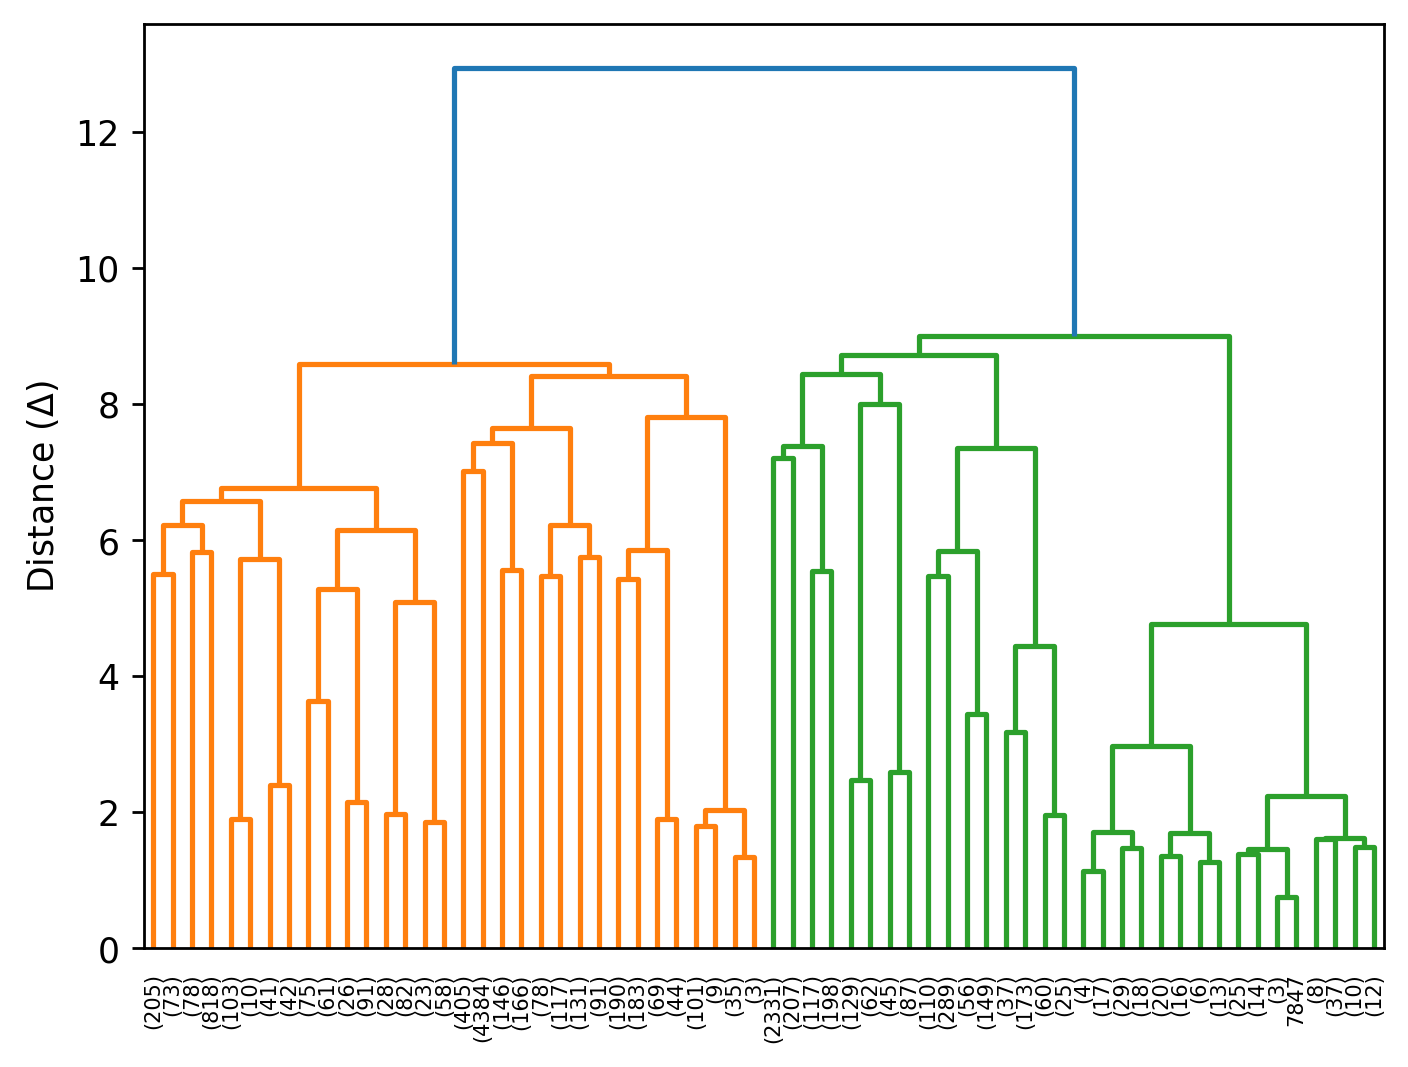

In [9]:
labtools.hierarchical_clustering(reduced_500)

<div style="text-align: center;">
    <h6>
        <b>Figure 4.</b> Ward's Clustering Dendrogram Results
    </h6>
</div>


From the dendrogram, we see that the optimal number of clusters is two. However, it would be interesting to investigate the sub-clusters that were formed under each main cluster because we can see that one main cluster has more points, so it is possible that we can further find subgroups under it. Let's check these both.

<div style="background-color:#711012; text-align:center; padding: 10px 0;">
    <h2 style="color: white; font-weight:bold">EDA on Main Clusters</h2>
</div>

Let's first check the two main clusters. This is what it looks when projected on the first two singular vectors:

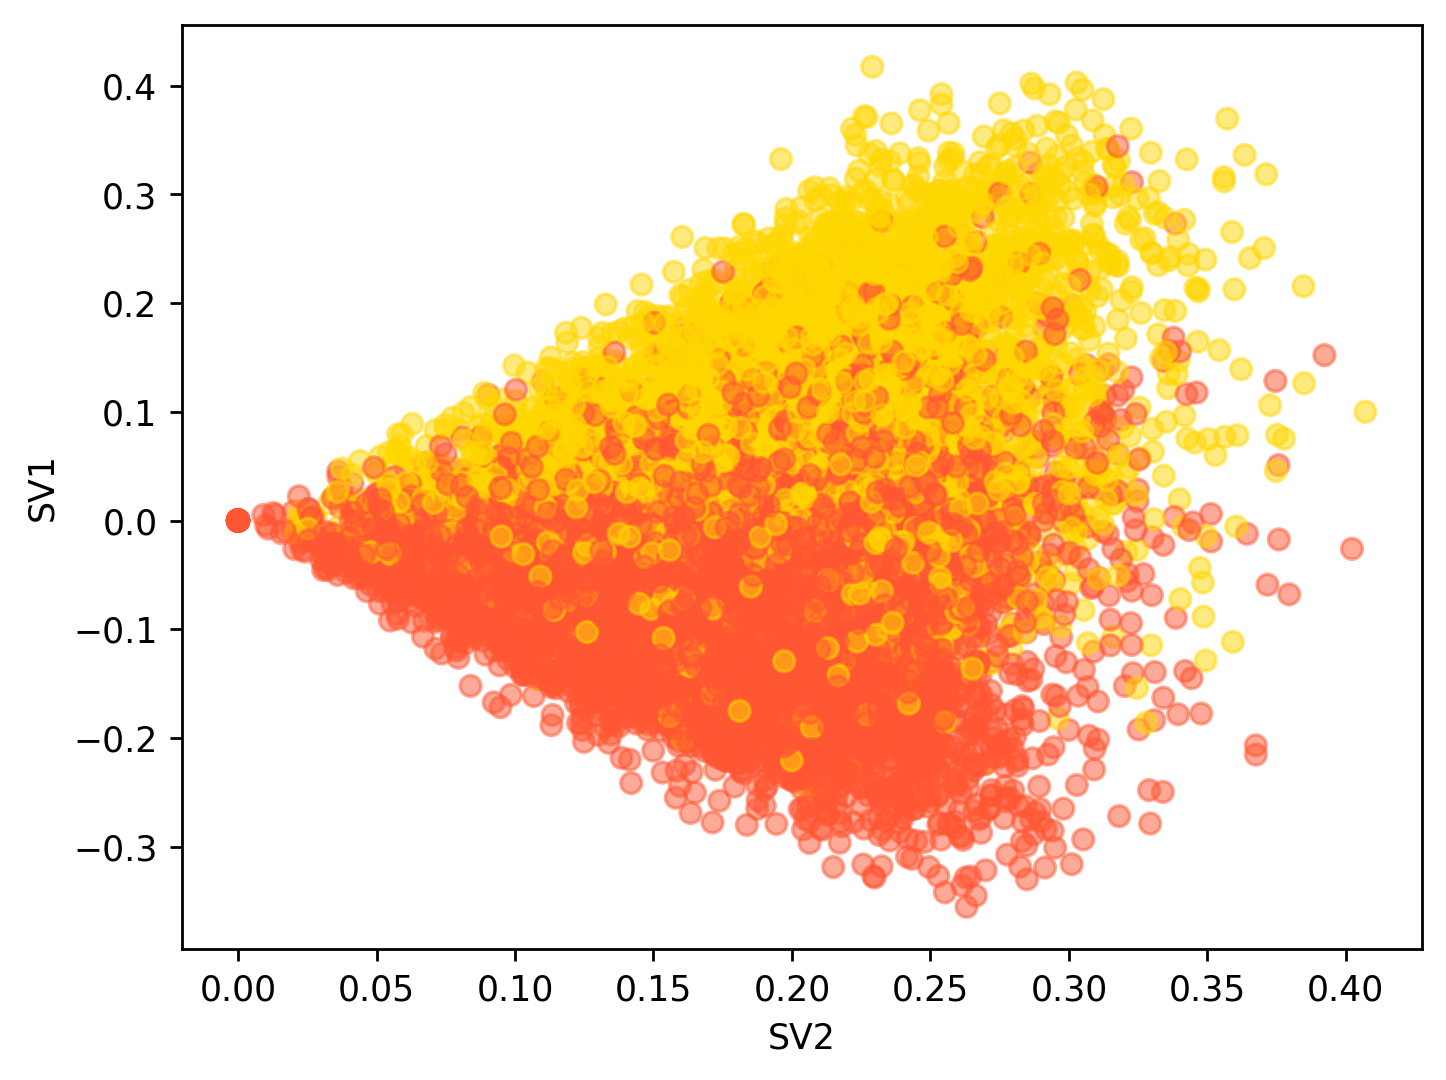

In [10]:
labtools.cluster_predict(reduced_500, df_500, show_viz=True)

<div style="text-align: center;">
    <h6>
        <b>Figure 5.</b> Clustering Results as Projected on the First Two Singular Vectors
    </h6>
</div>

This scatter plot for the 500 samples, transitioning from red to yellow, suggests a density gradient where the most heavily concentrated area in red represents the core or mainstream research topics within data science, and the yellow, less dense regions, indicate niche or emerging areas that may be gaining traction or represent specialized subfields. Similar looking scatter plot is seen for 250 samples supplemnt notebook.

Let's visualize the abstracts of the publications belonging to each main cluster using a word cloud to have an idea on what the cluster is all about.

In [11]:
clustered_df = labtools.cluster_predict(reduced_500, df_500, show_viz=False,
                               get_updated_df=True)

#### Cluster 1: 1995-2024 - 500 Samples

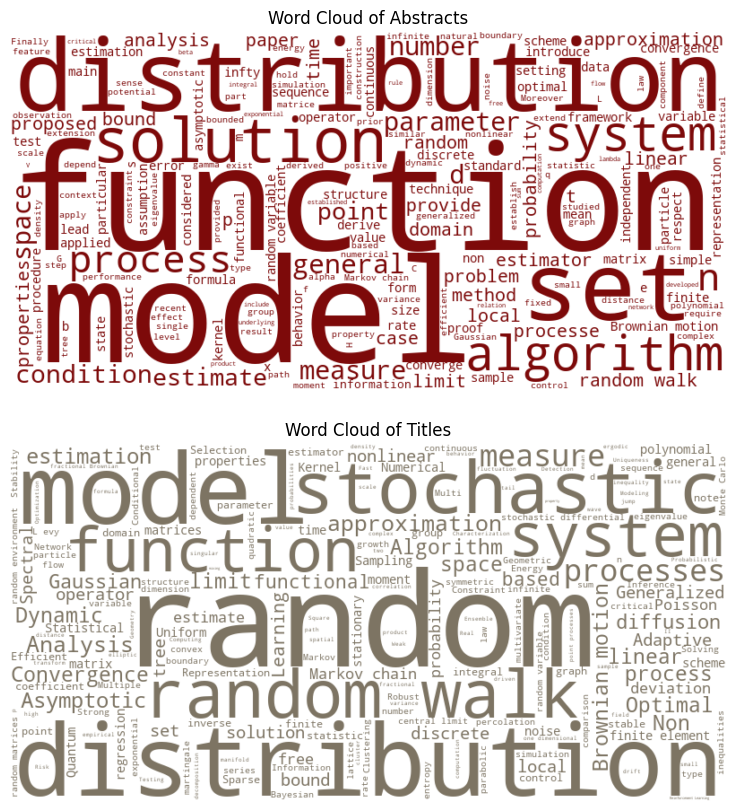

In [12]:
labtools.generate_wordclouds(clustered_df, cluster_number=1)

<div style="text-align: center;">
    <h6>
        <b>Figure 6.</b> Word Cloud of Main Cluster 1
    </h6>
</div>

#### Cluster 2: 1995-2024 - 500 Samples

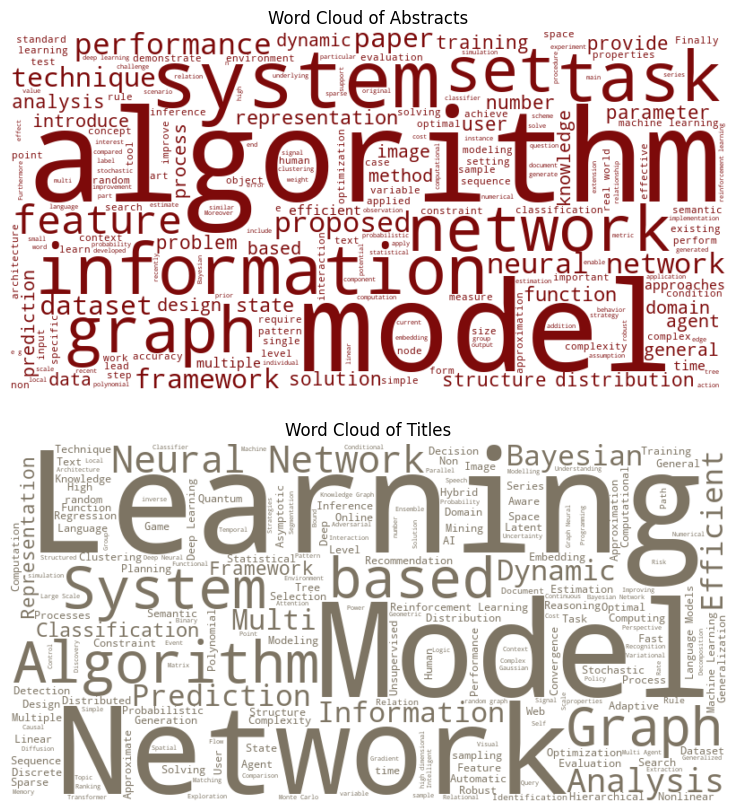

In [13]:
labtools.generate_wordclouds(clustered_df, cluster_number=2)

<div style="text-align: center;">
    <h6>
        <b>Figure 7.</b> Word Cloud of Main Cluster 2
    </h6>
</div>

**How imbalanced are our main clusters between 1995 and 2024?**

As we can see, Cluster 1 has significantly more points than Cluster 2. Because of this, it could be worth investigating its sub-clusters. 

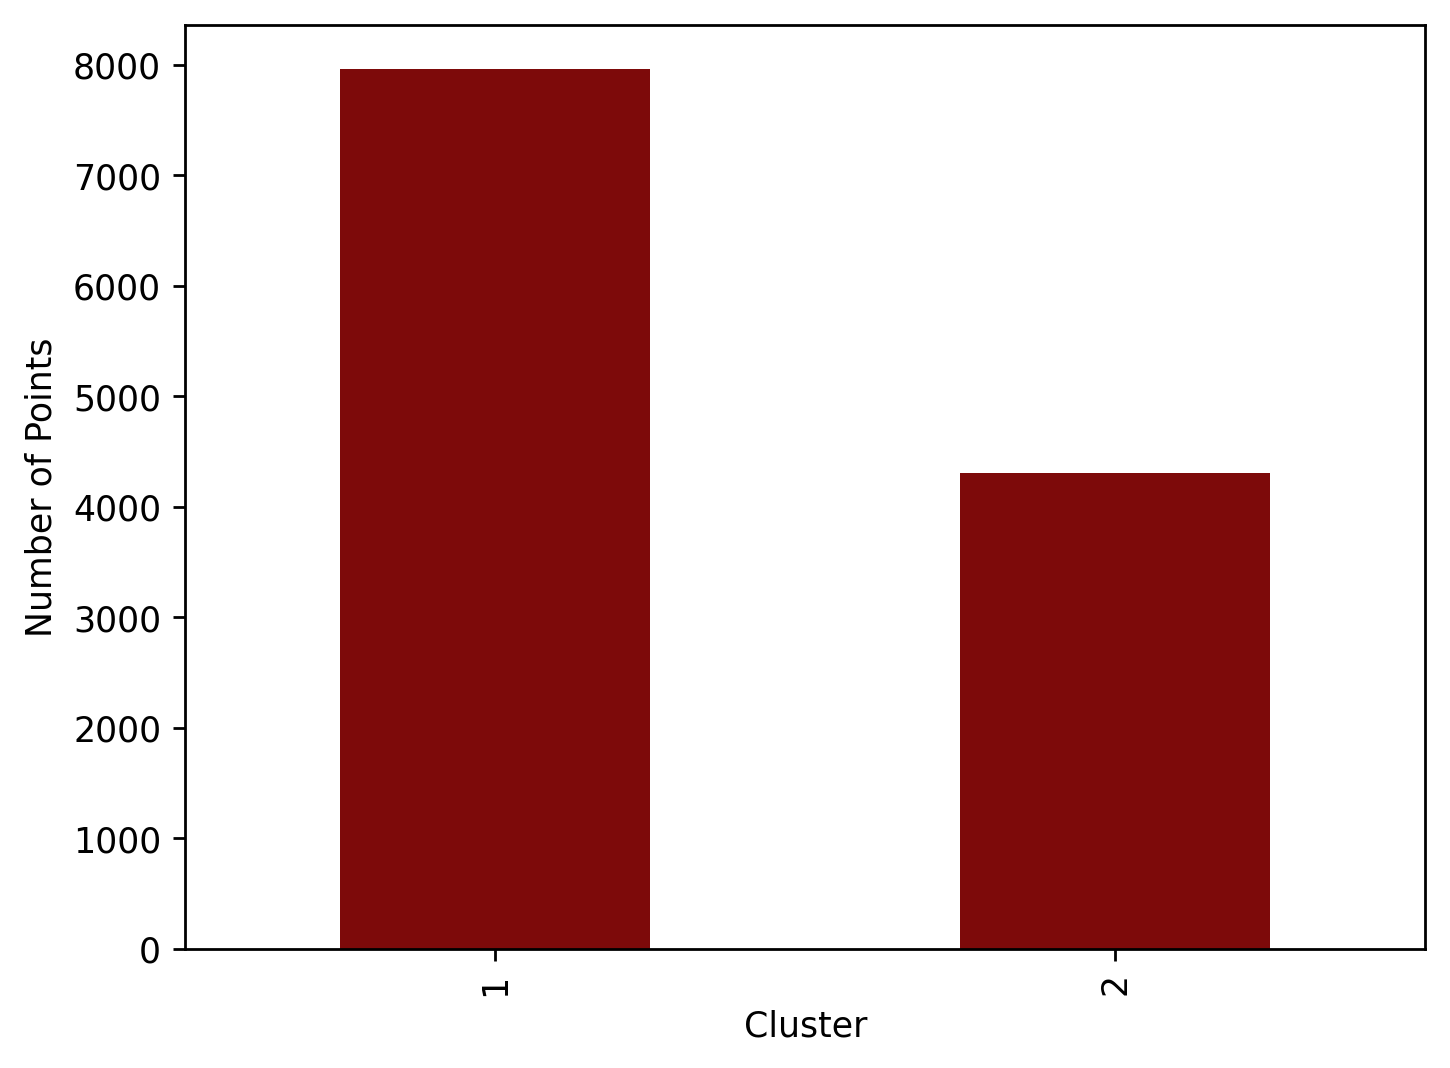

In [14]:
plt.figure(dpi=250)
clustered_df.cluster.value_counts().plot(kind='bar', color='#7d0a0a',
                                         xlabel='Cluster',
                                         ylabel='Number of Points');

<div style="text-align: center;">
    <h6>
        <b>Figure 8.</b> Visualizing the Distribution of Points to the Initial Clusters
    </h6>
</div>

To do this, we refer back to our dendrogram and change our threshold so that we would capture the subclusters of the large main cluster. Through eyeballing it, a threshold of 7.9 would suffice. The resulting distribution looks like this:

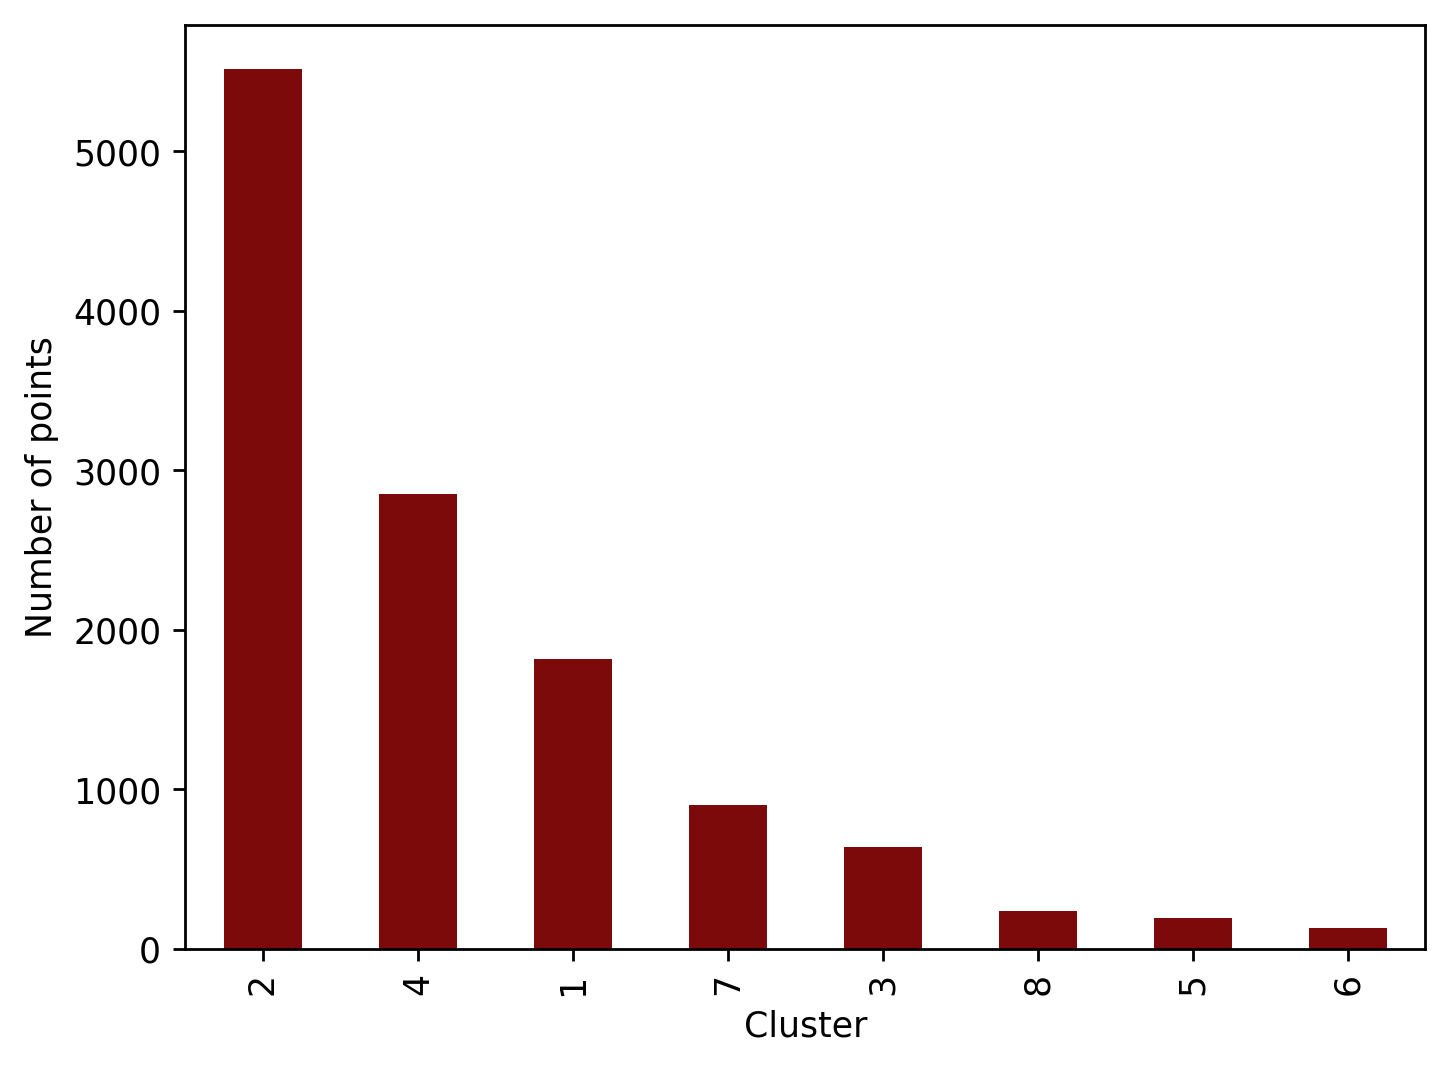

In [15]:
clustered_df = labtools.cluster_predict(reduced_500, df_500, show_viz=False, 
                               get_updated_df=True, thres=7.9)

plt.figure(dpi=250)
clustered_df.cluster.value_counts().plot(kind='bar', color='#7d0a0a', 
                                         xlabel='Cluster',
                                         ylabel='Number of points');

<div style="text-align: center;">
    <h6>
        <b>Figure 9.</b> Visualizing the Distribution of Points after Re-clustering
    </h6>
</div>

Although one cluster still dominates the others with respect to the number of points, the general distribution of the points improved. Let's see what words compose each of these clusters.

#### Subclustering

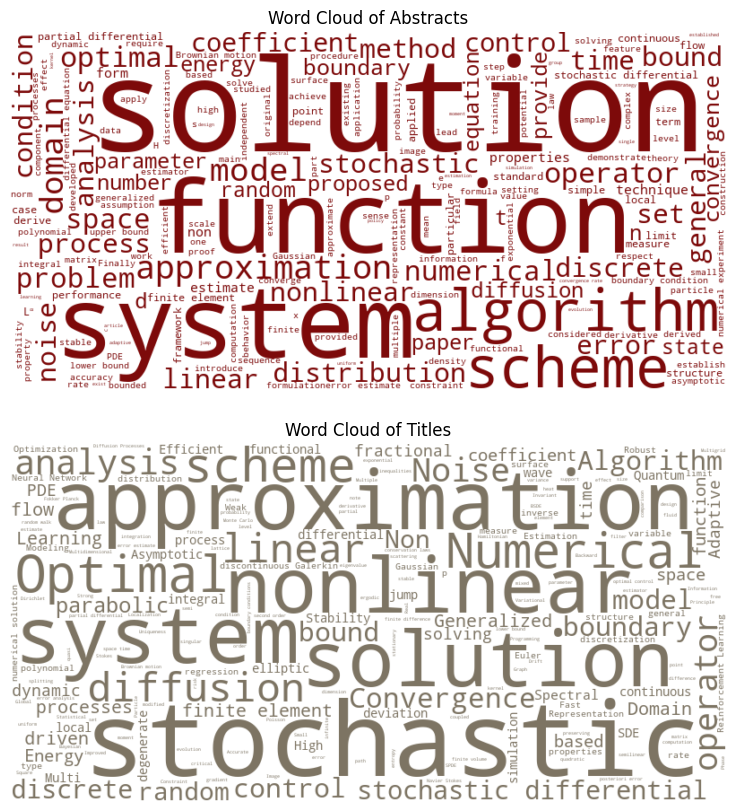

In [ ]:
# Cluster 1: 1995-2024 - 500 Samples
labtools.generate_wordclouds(clustered_df, cluster_number=1)

<div style="text-align: center;">
    <h6>
        <b>Figure 10.</b> Word Cloud of Final Cluster 1
    </h6>
</div>

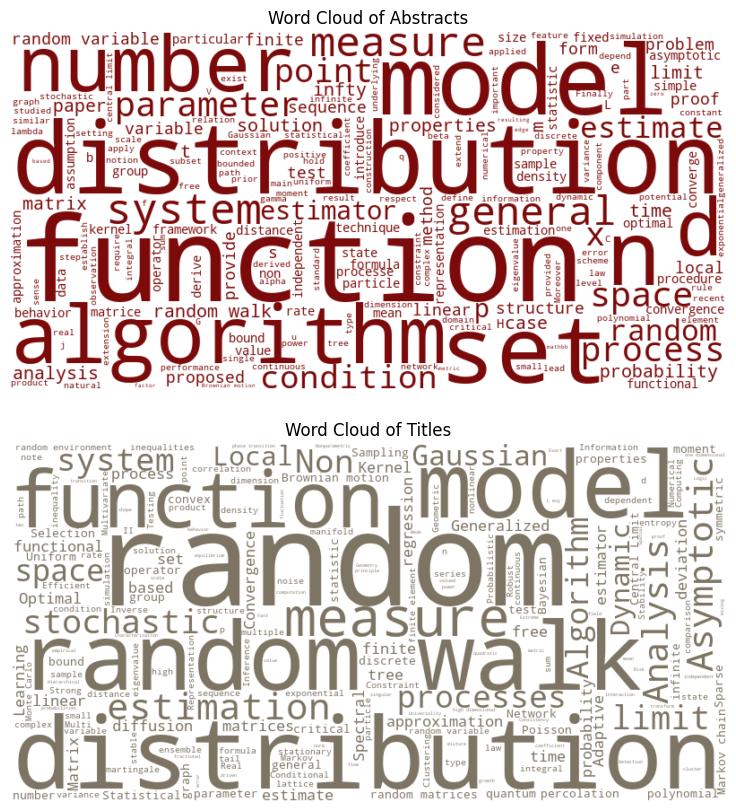

In [17]:
# Cluster 2: 1995-2024 - 500 Samples
labtools.generate_wordclouds(clustered_df, cluster_number=2)

<div style="text-align: center;">
    <h6>
        <b>Figure 11.</b> Word Cloud of Final Cluster 2
    </h6>
</div>

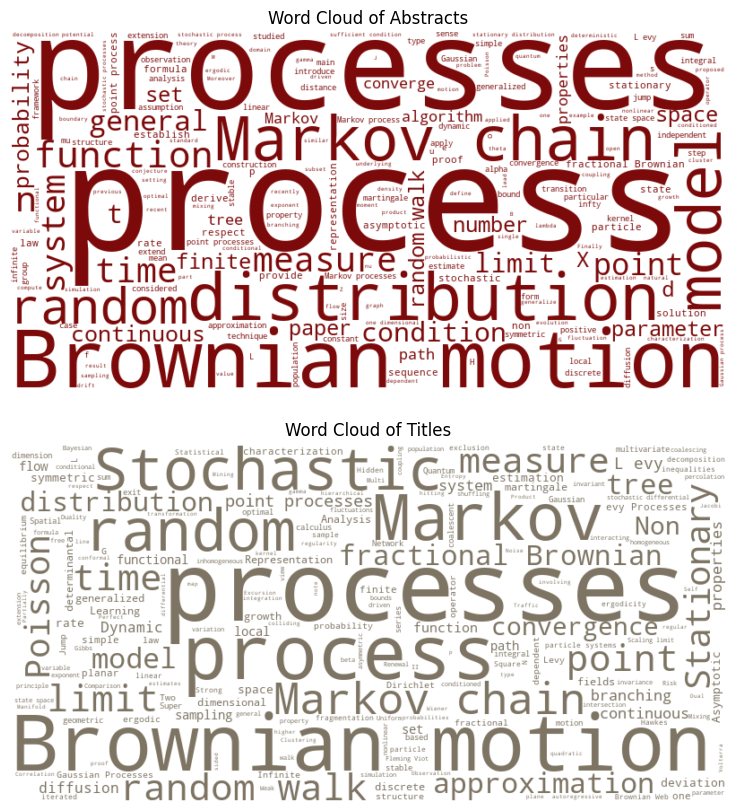

In [18]:
# Cluster 3: 1995-2024 - 500 Samples
labtools.generate_wordclouds(clustered_df, cluster_number=3)

<div style="text-align: center;">
    <h6>
        <b>Figure 12.</b> Word Cloud of Final Cluster 3
    </h6>
</div>

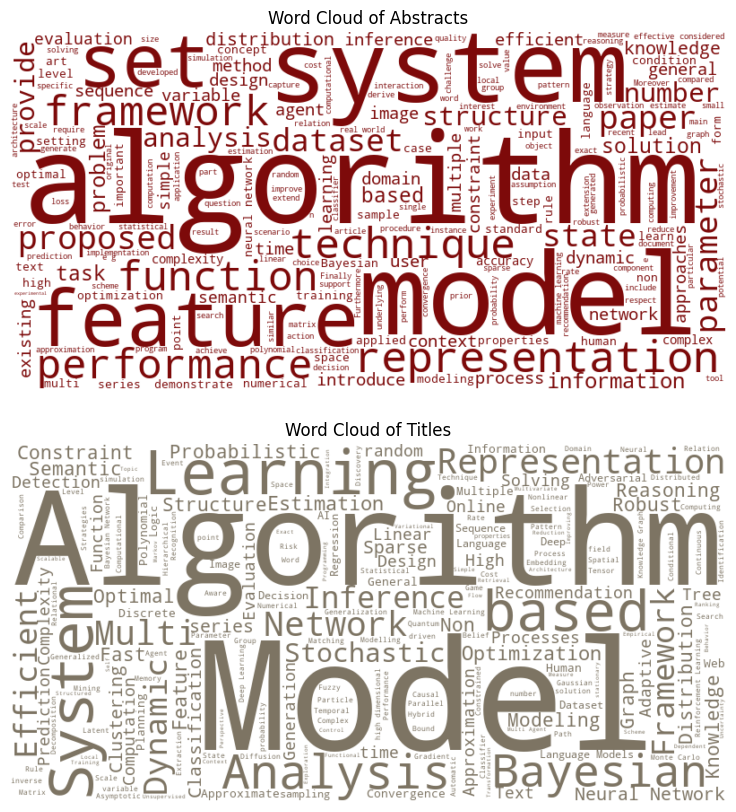

In [19]:
# Cluster 4: 1995-2024 - 500 Samples
labtools.generate_wordclouds(clustered_df, cluster_number=4)

<div style="text-align: center;">
    <h6>
        <b>Figure 13.</b> Word Cloud of Final Cluster 4
    </h6>
</div>

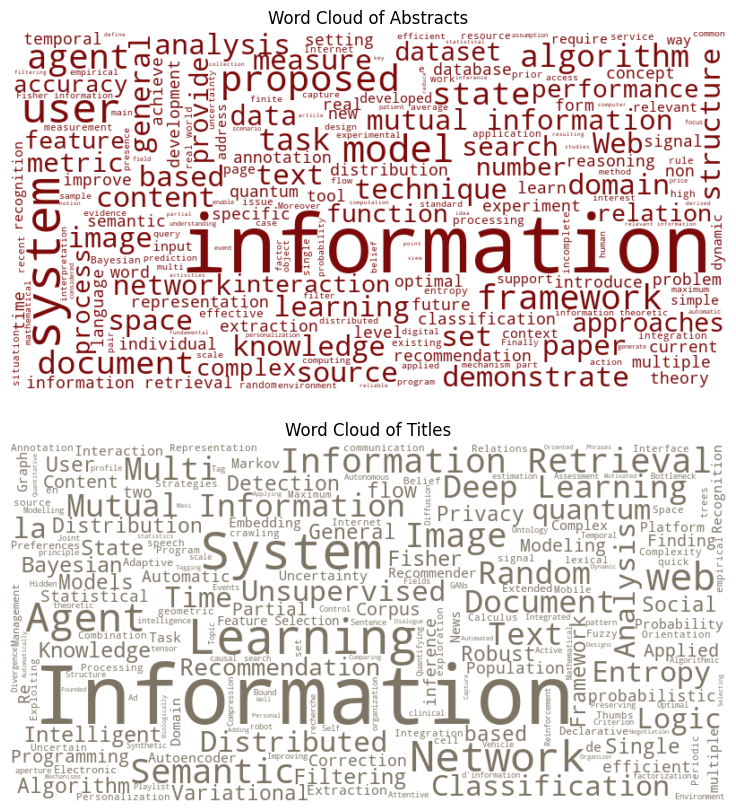

In [20]:
# Cluster 5: 1995-2024 - 500 Samples
labtools.generate_wordclouds(clustered_df, cluster_number=5)

<div style="text-align: center;">
    <h6>
        <b>Figure 14.</b> Word Cloud of Final Cluster 5
    </h6>
</div>

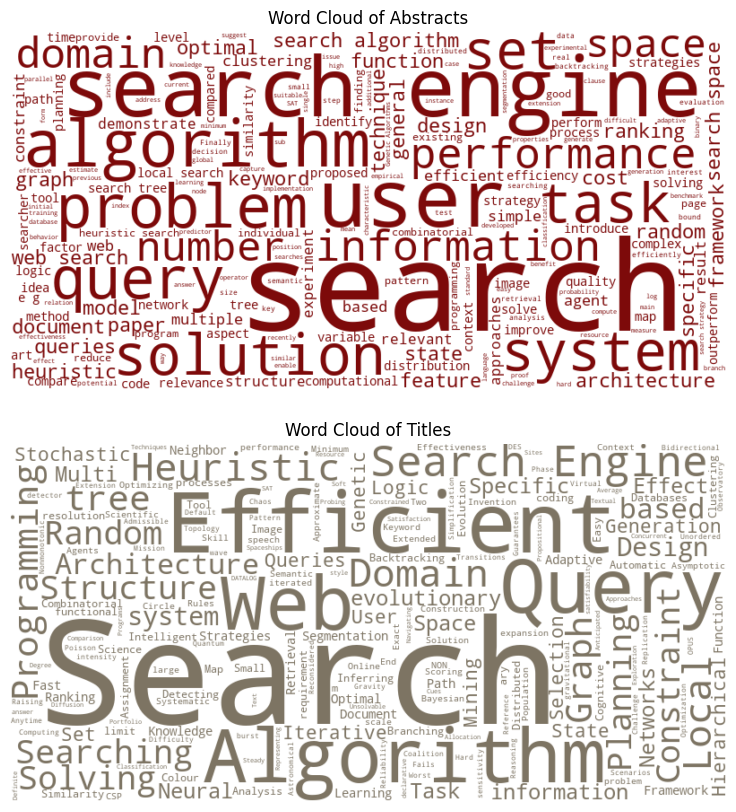

In [21]:
# Cluster 6: 1995-2024 - 500 Samples
labtools.generate_wordclouds(clustered_df, cluster_number=6)

<div style="text-align: center;">
    <h6>
        <b>Figure 15.</b> Word Cloud of Final Cluster 6
    </h6>
</div>

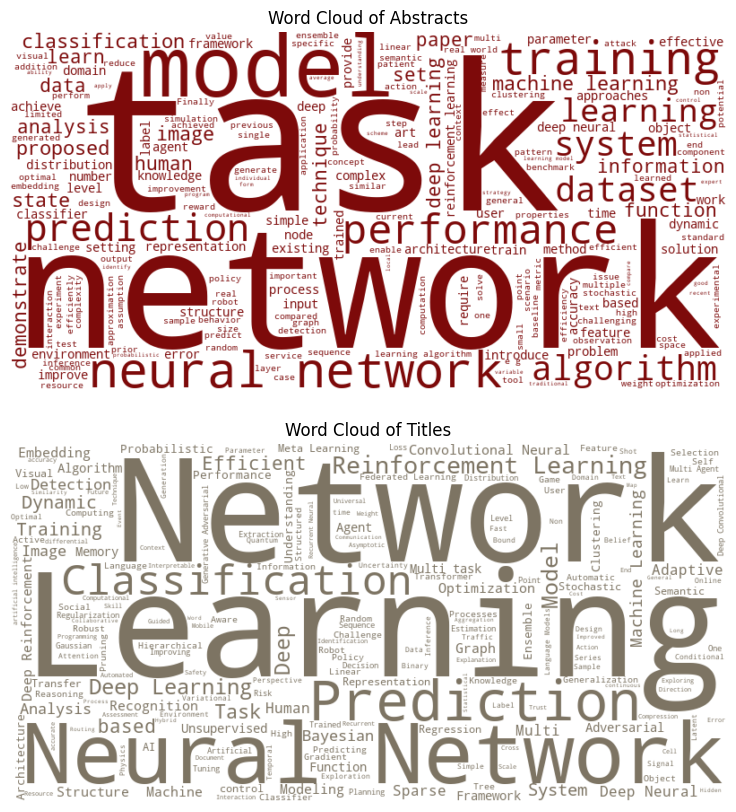

In [22]:
# Cluster 7: 1995-2024 - 500 Samples
labtools.generate_wordclouds(clustered_df, cluster_number=7)

<div style="text-align: center;">
    <h6>
        <b>Figure 16.</b> Word Cloud of Final Cluster 7
    </h6>
</div>

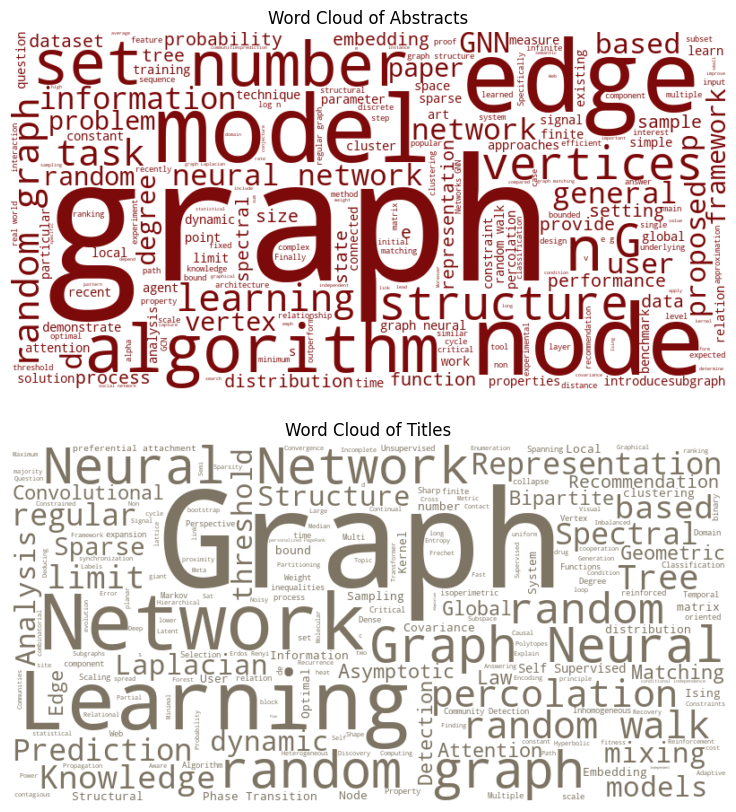

In [23]:
# Cluster 8: 1995-2024 - 500 Samples
labtools.generate_wordclouds(clustered_df, cluster_number=8)

<div style="text-align: center;">
    <h6>
        <b>Figure 17.</b> Word Cloud of Final Cluster 8
    </h6>
</div>

<div style="background-color:#711012; text-align:center; padding: 10px 0;">
    <h2 style="color: white; font-weight:bold">CLUSTER INTERPRETATION and INSIGHTS</h2>
</div>

### *Main Clusters*

#### *Cluster 1: "Statistical Methods and Theoretical Foundations"*

- *Abstract Keywords*: “Solution”, “System”, “Function”, “Estimate”, “Distribution”, and “Algorithm”
- *Title Keywords*: “Random Walk”, “Stochastic”, “Distribution”, and “Algorithm”
- *Interpretation*:
  - This cluster, with terms like "solution", "estimate", "distribution", “random walk” and "stochastic" points towards research that is grounded in statistical analysis and theoretical development. The focus here is on devising solutions and methods to understand the underlying distributions and behaviors of systems through stochastic modeling and inferential statistics.
- *Insights*:
  - In the first main cluster, we can observe that the common words from the studies inside the cluster are leaning to the two of the main categories chosen: Mathematics and Applied Statistics. Moreover, the heavy presence of these keywords reveals the strong representation of the said categories in the cluster. This is consistent with the actual number of volumes of studies published for these two categories as seen in our EDA.
  - Notably, it can also be observed that the presence of terms such as “convergence”, “brownian motion”, “accuracy rate”, and “diffusion” show how diverse the cluster is which can be an indication of further sub-clustering to identify the finer-grained clustering but still handling the number of clusters to be considered. 

#### *Cluster 2: Machine Learning, Network Analysis, and Algorithmic Learning*

- *Abstract Keywords*: "Network", "Information", "Model", “Graph”, "Function", and "Algorithm"
- *Title Keywords*: "Model", “Learning”, “Network”, “Classification”, “Neural Network”, and “Algorithm”
- *Interpretation*:
  - The second cluster, with " network ", " information ", “learning”, " function", and " algorithm" indicates a strong focus on applying algorithmic learning to network structures and graph analysis. This suggests a more applied approach, possibly exploring how data can be structured, analyzed, and learned from in complex networked environments, employing machine learning and neural network models.
- *Insights*:
  - In the Second Cluster, we can observe how the common words are from the recent emerging topics such as machine learning, network analysis and neural networks, and algorithmic learning which is recently enabled thanks to developments in artificial intelligence. Although our results from the second cluster is suggestive on the labelling of these studies as the emerging topics in data science, we cannot have the inference of labelling them as part of the “Emerging topics in Data Science” since the 250 samples here from different years is clustered all at once, missing the timeline identification for the clustering. Instead, it is due to its sheer numbers of the studies in the sample which suggests that there is large enough numbers from these areas of Data Science that are present in the past 30 years which can support topics revolving on this but sets no clear direction especially on recency.

#### *Main Clustering Insights*



- The division into two main clusters within the 500-sample subset highlights a nuanced categorization of research topics, indicative of the multidimensional nature of data science exploration. Each cluster represents a specialized area of focus, contributing uniquely to the overarching field of data science. Main cluster 1 likely emphasizes statistical methods and theoretical foundations, delving into foundational aspects of mathematics and statistics. Meanwhile, main cluster 2 appears to center on machine learning, network analysis, and algorithmic learning which showcases an applied approach to data science research.

- While there is a clear cut both clusters, there is an imbalance in the clusters leaning towards main cluster 1 which suggests that there are a large number of studies that support data science in terms of the two main categories mathematics and applied statistics. Also, it is worth to consider to further subcluster the two main clusters based on the observation on the smaller words in the word cloud for both clusters which are coming from different fields of studies for Data Science, which for example are in the domains of Machine Learning, Artificial Intelligence, and the application of Data Science to other studies such as Physics.


### *Sub-Clusters*

#### *Sub-Cluster Label 1: Computational Mathematics and Algorithmic Theory*

- *Abstract Keywords*: "Solution", "Approximation", "Numerical", "Stochastic", "Algorithm", And "Scheme"
- *Title Keywords*: “Solution”, “Stochastic”, “System”, “Scheme”, “Nonlinear” and “Algorithm”
- *Interpretation*:
  - This sub-cluster mainly have terms such as "solution", "approximation", "numerical", "stochastic", “algorithm”, "boundary", and "scheme" which seems to be concerned with computational mathematics and the development of algorithmic theory for solving complex mathematical problems, particularly those involving stochastic processes or boundary conditions.
- *Insights*:
  - Addressing complex mathematical problems, especially those involving stochastic processes or boundary conditions, this sub-cluster pioneers numerical and algorithmic solutions. It develops computational methodologies for accurate simulations and analyses, facilitating advancements in scientific research and engineering applications.

#### *Sub-Cluster Label 2: Statistical Analysis and Probabilistic Modelling*

- *Abstract Keywords*: “Function”, "Estimate", "Probability", "Model", And "Distribution"
- *Title Keywords*: “Random”, “Random Walk”, “Gaussian”, “Distribution”, “Stochastic” and “Algorithm”
- *Interpretation*:
  - This sub-cluster likely involves statistical analysis and probabilistic modeling, as evidenced by terms like "estimate", "function", "probability", "model", and "distribution". The focus is probably on the development of statistical methods for the estimation and prediction in uncertain or random environments.
- *Insights*:
  - Grounded in statistical analysis and probabilistic modeling, this sub-cluster linked to Data Science pioneers methods for estimation and prediction in uncertain environments. It contributes to robust decision-making processes and predictive accuracy, playing a pivotal role across various industries such as finance, healthcare, and marketing.

#### *Sub-Cluster Label 3: Markov Processes and Stochastic Dynamics*

- *Abstract Keywords*: "Markov", "Brownian Motion", "Stochastic Processes", and "Convergence"
- *Title Keywords*: “Markov”, “Brownian motion”, “Markov Chain”, “Poisson”, “Stochastic” and “Approximation”
- *Interpretation*:
  - This sub-cluster have recurrence of terms such as "Markov", "Brownian Motion", "stochastic processes", and "convergence" suggesting a concentration on Markov processes, stochastic dynamics, and related mathematical frameworks. This research could involve exploring the properties and behaviors of systems subject to random fluctuations and transitions.
- *Insights*:
  - Focused on Markov processes, stochastic dynamics, and related frameworks, this sub-cluster investigates the behaviors of dynamic systems under random fluctuations. It advances the understanding of dynamic phenomena, contributing to the modeling and analysis of complex systems in diverse scientific and engineering domains.

#### *Sub-Cluster Label 4: Machine Learning and Bayesian Inference*

- *Abstract Keywords*: "Bayesian", “performance”, "model", "feature", "algorithm", and "parameter”
- *Title Keywords*: “Bayesian”, “Model”, “Representation”, “Regression”, “Classification” and “Algorithm”
- *Interpretation*:
  - This sub-cluster seems to revolve around machine learning methodologies and Bayesian inference, indicated by terms like "Bayesian", "learning", "network", "algorithm", and "representation" It likely examines the application of Bayesian methods in machine learning to improve decision-making processes and predictive accuracy.
- *Insights*:
  - This sub-cluster explores the integration of Bayesian inference into machine learning methodologies for enhanced decision-making processes. It leverages Bayesian principles to improve predictive accuracy and model interpretability, with applications spanning from personalized medicine to financial risk assessment.

#### *Sub-Cluster Label 5: Semantic Analysis and Information Systems*

- *Abstract Keywords*: "Dataset," "User," "Semantic," "Feature," "Information," And "Learning"
- *Title Keywords*: “Information Retrieval”, “Semantic”, “Distribution”, and “Web”
- *Interpretation*:
  - This sub-cluster appears to focus on the intersection of semantic analysis, information retrieval, and the design of information systems. Keywords such as "dataset," "user," "semantic," "feature," "information," and "learning" suggest a strong emphasis on how users interact with information retrieval systems, how features are extracted for semantic analysis, and how learning algorithms are applied to improve these systems.
- *Insights*:
  - This sub-cluster delves into the intricacies of semantic analysis and the design of information retrieval systems. It explores user interactions, semantic feature extraction, and the utilization of learning algorithms to optimize information retrieval processes, enhancing user experience and system efficiency.

#### *Sub-Cluster Label 6: Search Algorithms and Heuristic Methods*

- *Abstract Keywords*: "Search Engine”, “Query," "Optimization," "Algorithm," "Problem," And "Solution"
- *Title Keywords*: “Search Engine”, “Queries”, “Heuristic”, “Programming”, and “Web”
- *Interpretation*:
  - This sub-cluster emphasizes on search algorithms, particularly heuristic and stochastic search methods. The prominence of terms like “search engine”, "query," "optimization," "algorithm," "heuristic," and "search engine" indicates research into efficient search strategies in large and complex datasets or problem spaces, possibly within the context of web search engines and database querying.
- *Insights*:
  - Focusing on search algorithms and optimization methodologies, this sub-cluster investigates innovative search strategies, particularly heuristic and stochastic approaches. It addresses challenges in large-scale dataset searches, aiming to improve query efficiency and result relevance in complex information retrieval scenarios.

#### *Sub-Cluster Label 7: Neural Networks, Deep Learning and Predictive Analytics*

- *Abstract Keywords*: "Network", "Model", “Neural Network”, “Training”, “Prediction”, “Complex” 
- *Title Keywords*: “Network”, “Learning”, “Neural Network”, "Classification", "Prediction", And "Training"
- *Interpretation*:
  - This sub-cluster is centered on neural networks and deep learning techniques. The presence of terms such as "neural network," "deep learning," "classification," "prediction," and "training" suggests a focus on the development and application of deep neural architectures for various predictive tasks and the analysis of their performance.
- *Insights*:
  - Centered on neural networks and deep learning techniques, this sub-cluster advances the development and application of deep neural architectures for predictive analytics. It explores cutting-edge methodologies for classification, prediction, and training, driving advancements in various domains through sophisticated predictive modeling.

#### *Sub-Cluster Label 8: Graph Theory, Deep Learning, and Network Analysis*

- *Abstract Keywords*: "Graph", "Network", "Structure", "Vertices", “Subgraph”, And "Embedding"
- *Title Keywords*: “Network”, “Graph”, “Neural Network”, "Laplacian", "Convolutional", And "Convergence"
- *Interpretation*:
  - This sub-cluster focuses on keywords like "graph," "network," "structure," "vertices," and "embedding" that points to studies in graph theory and network analysis. Research in this sub-cluster likely deals with the properties of graphs, the dynamics of networks, and the development of algorithms for graph-related problems, possibly in the field of social networks or communication networks.
- *Insights*:
  - This sub-cluster focuses on graph theory, deep learning and network analysis, investigating properties, dynamics, and algorithmic solutions for complex networked systems. This field of study linked to Data Science contributes to understanding network structures and behaviors, with main focus on its applications in other diverse fields such as social networks, transportation systems, and biological networks.


<div style="background-color:#711012; text-align:center; padding: 10px 0;">
    <h2 style="color: white; font-weight:bold">CLUSTER INSIGHTS COMPARISON BETWEEN 250-SAMPLES AND 500-SAMPLES</h2>
</div>

### *Key Insights for the 250 samples and 500 samples clustering results:*

#### *Main difference for Main Clusters*

- The 250-sample subset leans more towards probabilistic modeling and algorithm optimization, whereas the 500-sample subset broadens the scope to include general statistical methods and network analysis combined with machine learning techniques which might be the result of the imbalance in the main cluster for 500-sample subset.

#### *Key difference for Sub-clusters*

The comparison will help us understand the consistency or divergence of research themes within the field of data science, which encompasses computer science, mathematics, and applied statistics:

- Semantic Analysis and Information Systems (500-sample) vs. Information Retrieval and Semantic Search (250-sample):
Both sub-clusters share a focus on the retrieval and semantic analysis of information. They are likely to encompass studies on search algorithms, user interaction with data systems, and the optimization of these systems to improve relevance and understanding of user queries and data semantics.

- Search Algorithms and Heuristic Methods (500-sample) vs. Algorithmic Development and System Optimization (250-sample):
These two sub-clusters both emphasize the development of algorithms. While the former seems to concentrate on search algorithms and heuristic methods, the latter appears to be broader, including system optimization. Both are integral to solving complex computational problems within data science.

- Neural Networks and Deep Learning (500-sample) vs. Machine Learning and Predictive Modelling (250-sample):
Deep learning is a subset of machine learning, so these sub-clusters align closely. They cover the creation, training, and evaluation of neural network models and their application in predictive analytics, a cornerstone of data science.

- Graph Theory and Network Analysis (500-sample) vs. Graph Theory and Network Dynamics (250-sample):
Both of these sub-clusters clearly focus on the study of graphs and networks. They represent a research area dedicated to understanding the structure and behavior of interconnected systems, which is important in many data science applications such as social network analysis and internet topology.

- Computational Mathematics and Algorithmic Theory (500-sample) vs. Numerical Methods and Stochastic Analysis (250-sample):
These sub-clusters are closely related, with both delving into the numerical and stochastic methods used in data science. The emphasis is on developing mathematical algorithms to solve equations and model uncertainties, critical for simulations and predictions in data science.

- Statistical Analysis and Probabilistic Modelling (500-sample) vs. Random Matrices and Eigenvalue Distributions (250-sample):
While the 500-sample sub-cluster has a broader focus on statistical methods, the 250-sample sub-cluster seems more specialized in matrix theory. However, both are concerned with understanding randomness and probability, which are fundamental in statistical data analysis.

- Markov Processes and Stochastic Dynamics (500-sample) vs. Stochastic Calculus and Theoretical Physics (250-sample):
These sub-clusters share a focus on stochastic processes and their applications. The 500-sample set might be more aligned with practical dynamics and applications in data science, while the 250-sample set could also extend to theoretical physics, indicating a more interdisciplinary approach.

- Machine Learning and Bayesian Inference (500-sample) vs. Artificial Intelligence and Data Architecture (250-sample):
Bayesian inference is a method within machine learning and AI for making probabilistic statements. This sub-cluster from the 500-sample set likely focuses on probabilistic modeling within AI, while the 250-sample set includes a broader range of AI topics, possibly including the design of data structures and architectures.

In summary, the comparison reveals that while there are slight variations in focus as initially expected by the sample difference, the core areas of research within data science remain consistent across the two sample sets. The fields of algorithm development, machine learning, statistical analysis, and graph theory are central pillars in both, reflecting the interdisciplinary and multifaceted nature of data science research.